# 잔차 분석
잔차 = 실제값 - 예측값  
'+' 면 예측이 낮음(언더)  
'-' 면 예측이 높음(오버)  
구조적 문제를 잡기위한 분석

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [12]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_realistic_retail_data(
    n_sku=200, 
    start="2024-01-01", 
    end="2025-12-31"
):
    dates = pd.date_range(start, end, freq="W-MON")
    rows = []

    for sku in range(1, n_sku+1):
        base = np.random.randint(10, 60)  # 베이스 수요
        trend = np.random.uniform(-0.05, 0.05)  # 미세 우상향/우하향
        noise_scale = np.random.uniform(3, 8)
        
        for i, date in enumerate(dates):
            seasonal = 10 * np.sin(2 * np.pi * (i / 52))  # 년간 seasonality
            noise = np.random.normal(0, noise_scale)

            y = base + (i * trend) + seasonal + noise
            y = max(0, int(y))

            cat = np.random.choice([
                "TV","냉장고","세탁기","건조기","공기청정기","전자레인지","모니터",
                "노트북","스마트폰","청소기","에어컨","프린터","식기세척기"
            ])

            rows.append([date, sku, y, cat])

    df = pd.DataFrame(rows, columns=["target_date", "sku_id", "y", "cat_low"])
    return df

df_actual = generate_realistic_retail_data()
df_actual.head()


,target_date,sku_id,y,cat_low
0,2024-01-01,1,49,청소기
1,2024-01-08,1,54,세탁기
2,2024-01-15,1,50,공기청정기
3,2024-01-22,1,47,건조기
4,2024-01-29,1,54,공기청정기


In [13]:
def generate_predictions(df):
    df = df.copy()
    np.random.seed(123)


    df["y_pred"] = df["y"] + np.random.normal(0, 5, size=len(df))
    df["y_pred"] = df["y_pred"].clip(0)  # 음수 방지
    return df

df_pred = generate_predictions(df_actual)
df_pred.head()


,target_date,sku_id,y,cat_low,y_pred
0,2024-01-01,1,49,청소기,43.571847
1,2024-01-08,1,54,세탁기,58.986727
2,2024-01-15,1,50,공기청정기,51.414892
3,2024-01-22,1,47,건조기,39.468526
4,2024-01-29,1,54,공기청정기,51.106999


In [14]:
df = df_actual.merge(df_pred[["target_date","sku_id","y_pred"]],
                     on=["target_date","sku_id"],
                     how="inner")

df["residual"] = df["y"] - df["y_pred"]
df.head()


,target_date,sku_id,y,cat_low,y_pred,residual
0,2024-01-01,1,49,청소기,43.571847,5.428153
1,2024-01-08,1,54,세탁기,58.986727,-4.986727
2,2024-01-15,1,50,공기청정기,51.414892,-1.414892
3,2024-01-22,1,47,건조기,39.468526,7.531474
4,2024-01-29,1,54,공기청정기,51.106999,2.893001


- 과소 예측 경향
- 직전 주 판매가 높으면 과대 예측하는 경향도 보임
- 급변 패턴엔 약하고 안정적인 구간에선 정확

In [16]:
def metrics(df, y_col="y", pred_col="y_pred"):
    y = df[y_col].values
    y_pred = df[pred_col].values

    mae = np.mean(np.abs(y - y_pred))
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    mape = np.mean(np.abs((y - y_pred) / (y + 1e-9))) * 100
    smape = np.mean(2*np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred) + 1e-9)) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "SMAPE": smape
    }

metrics(df)


{'MAE': np.float64(3.9381766013188932),
 'RMSE': np.float64(4.9449365945832335),
 'MAPE': np.float64(3177077064.349899),
 'SMAPE': np.float64(19.13294056698793)}

In [17]:
# ===============================================
# 1. Residual Diagnostics (잔차 분석)
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"



BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

EVAL = BASE / "eval_2025_pred_vs_actual.csv"
FEAT = BASE / "features_all.csv"

df_eval = pd.read_csv(EVAL, parse_dates=["target_date"])
df_feat = pd.read_csv(FEAT, parse_dates=["target_date"])[["target_date","sku_id","cat_low"]]

df = df_eval.merge(df_feat, on=["target_date", "sku_id"], how="left")

# 잔차(residual)
df["residual"] = df["y"] - df["y_pred"]

display(df.head())

print("데이터 수:", len(df))


,target_date,sku_id,y,y_pred,cat_low,residual
0,2025-01-06,1,47,47.454878,TV,-0.454878
1,2025-01-13,1,45,45.019168,TV,-0.019168
2,2025-01-20,1,34,44.547307,TV,-10.547307
3,2025-01-27,1,43,41.577195,TV,1.422805
4,2025-02-03,1,43,41.813556,TV,1.186444


데이터 수: 10712


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


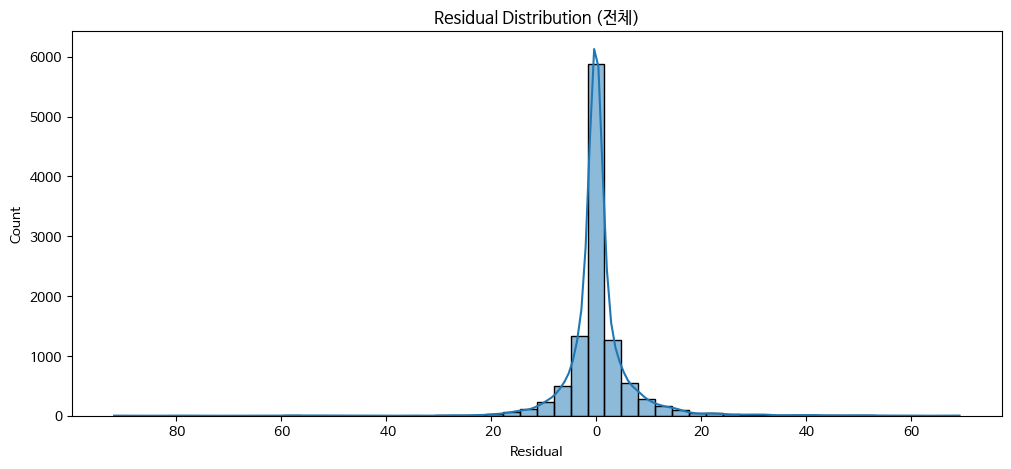

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


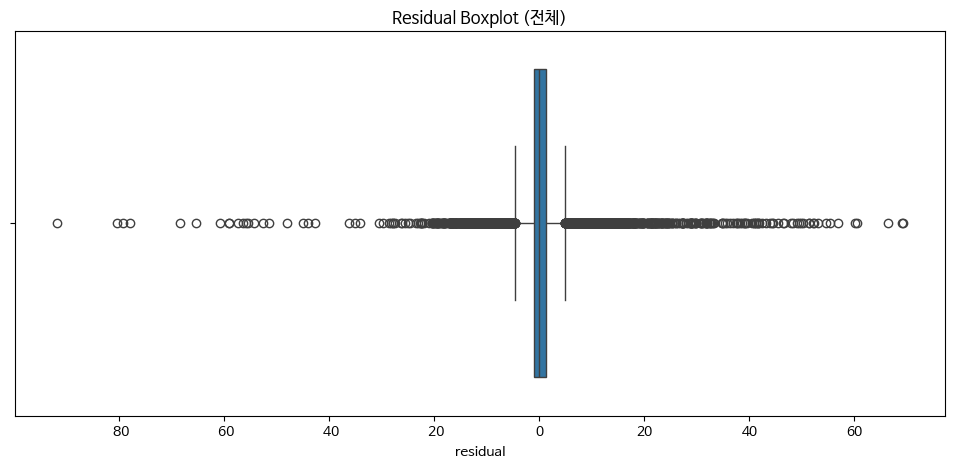

In [18]:
# ===============================================
# 2. Residual Distribution
# ===============================================

plt.figure(figsize=(12,5))
sns.histplot(df["residual"], kde=True, bins=50)
plt.title("Residual Distribution (전체)")
plt.xlabel("Residual")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=df["residual"])
plt.title("Residual Boxplot (전체)")
plt.show()


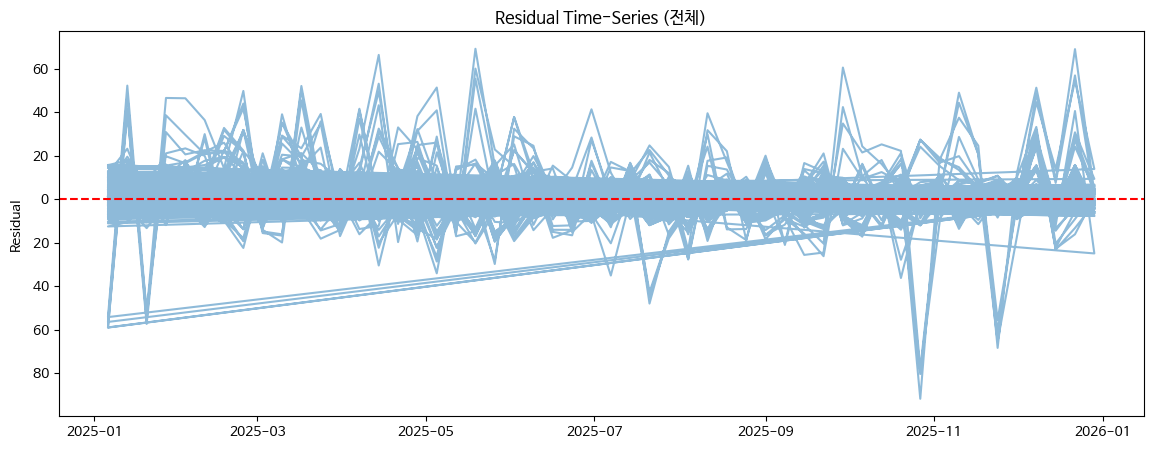

In [19]:
# ===============================================
# 3. Time-Series Residuals
# ===============================================

plt.figure(figsize=(14,5))
plt.plot(df["target_date"], df["residual"], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Time-Series (전체)")
plt.ylabel("Residual")
plt.show()


In [20]:
# ===============================================
# 4. Category-level Residual Diagnostics
# ===============================================

cat_res = df.groupby("cat_low")["residual"].agg(["mean","std","median","min","max"])
display(cat_res.sort_values("mean"))


,mean,std,median,min,max
cat_low,,,,,
오븐,-0.268187,2.310751,-0.303931,-7.416670,9.506210
데스크탑,-0.227605,2.400519,0.027081,-10.481551,5.969490
세탁기,-0.141082,2.590559,-0.303931,-12.480167,12.112533
건조기,-0.114755,3.121544,-0.303931,-16.910460,17.957371
프린터,-0.113838,2.832997,-0.294165,-7.383573,9.728218
냉장고,-0.105064,3.646835,0.051810,-13.779395,19.819623
라우터,-0.050288,6.822369,1.267273,-19.495053,14.765670
식기세척기,-0.027222,1.955085,-0.075724,-4.123612,5.215687
믹서기,0.033976,3.570342,0.233723,-10.545475,11.183651


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


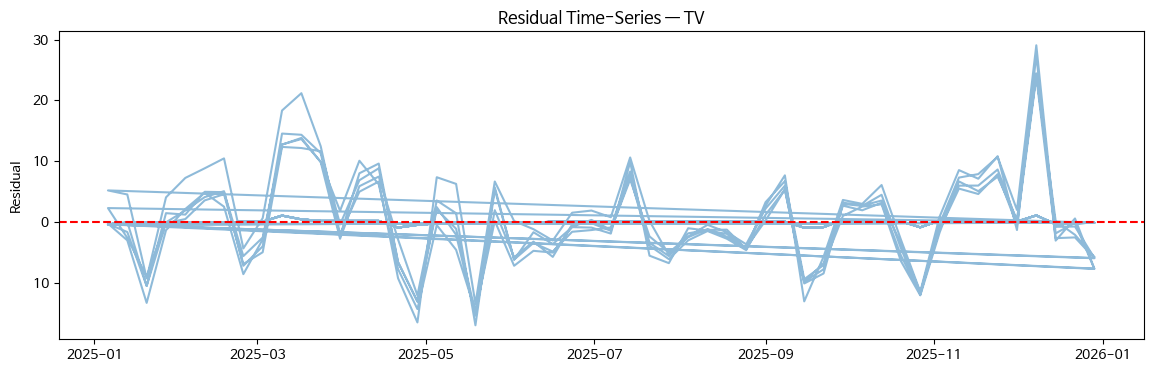

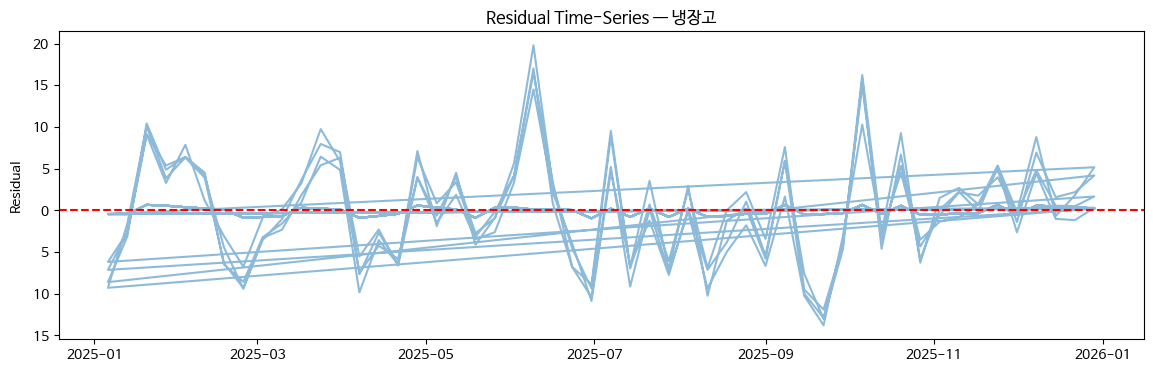

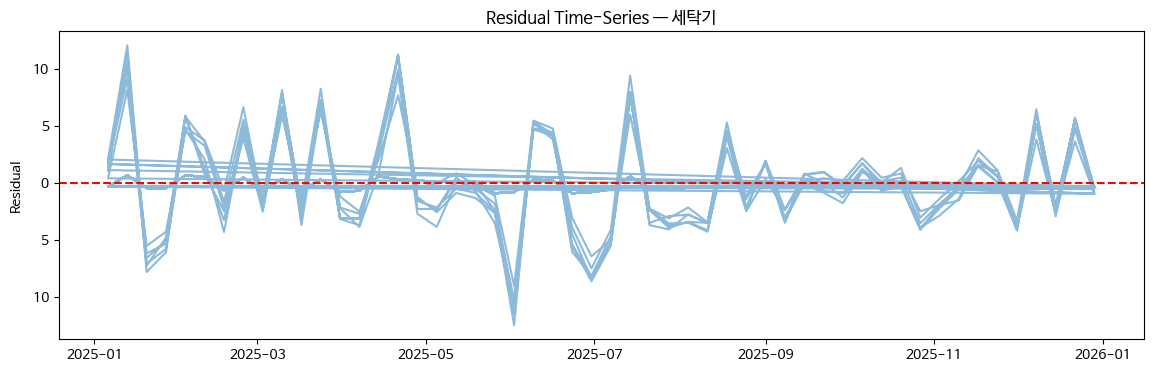

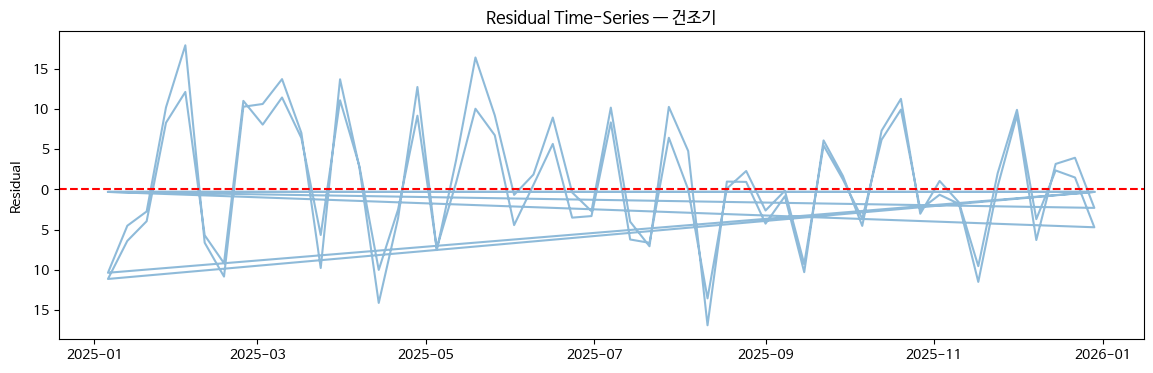

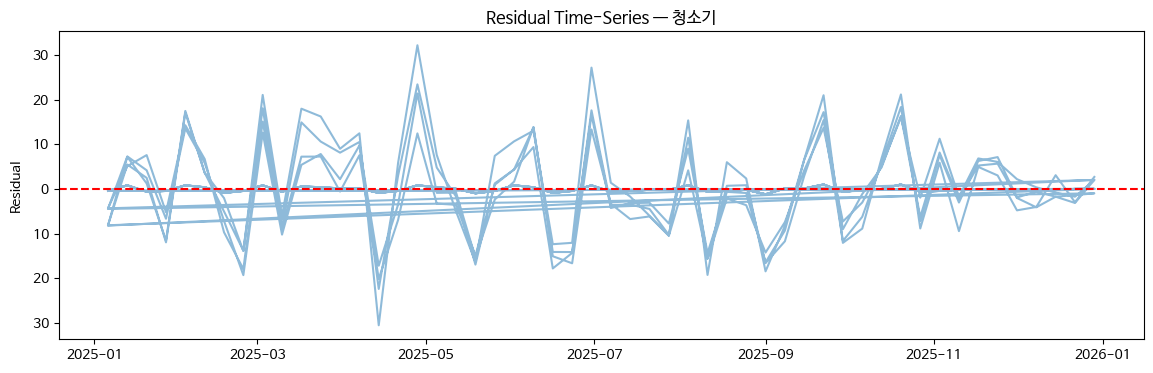

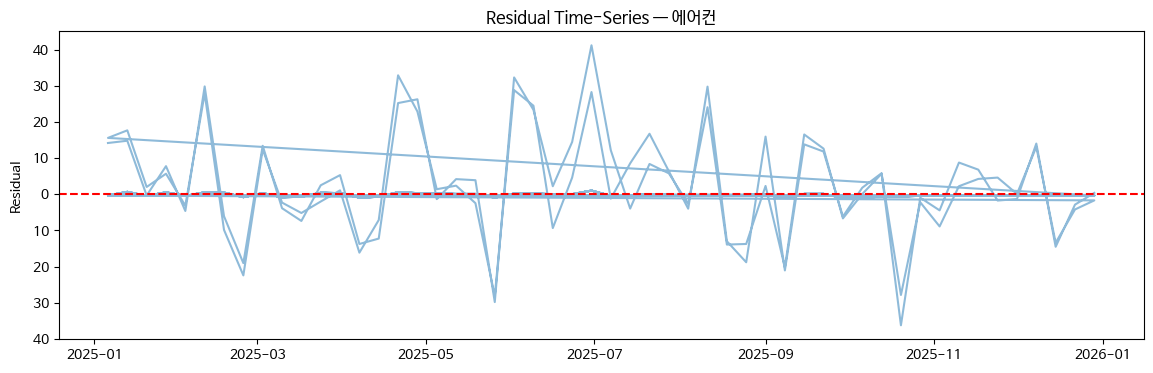

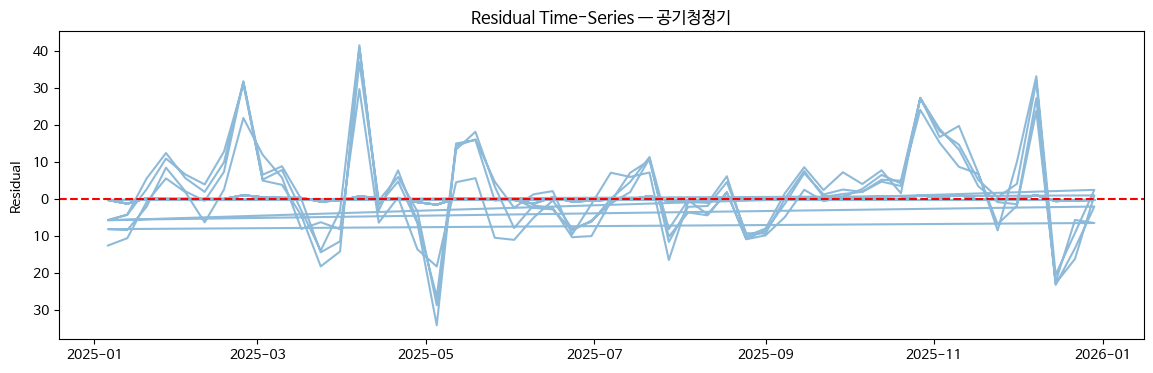

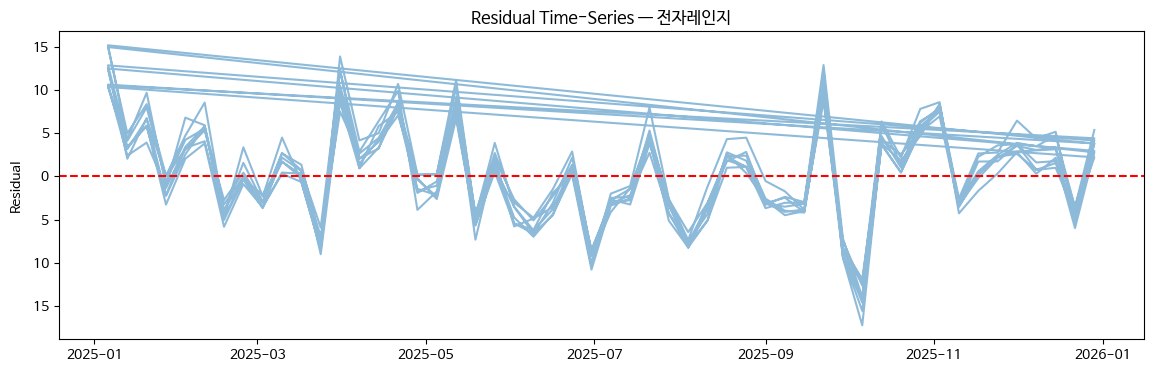

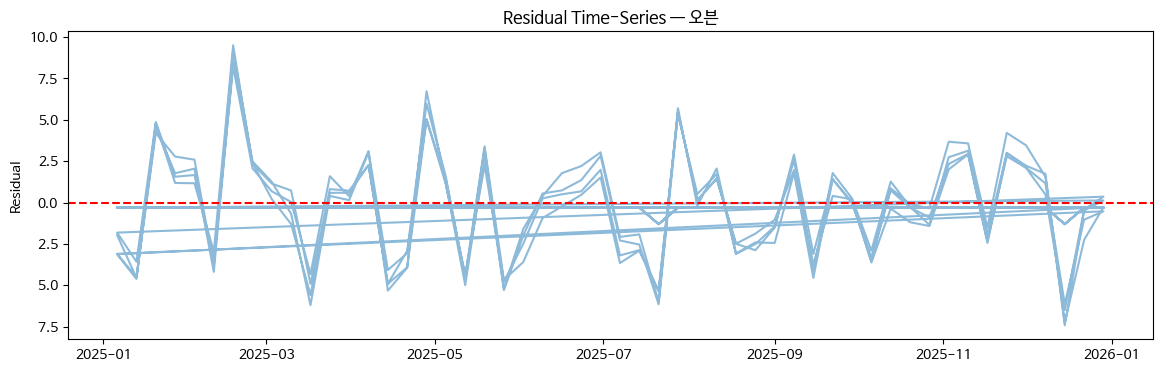

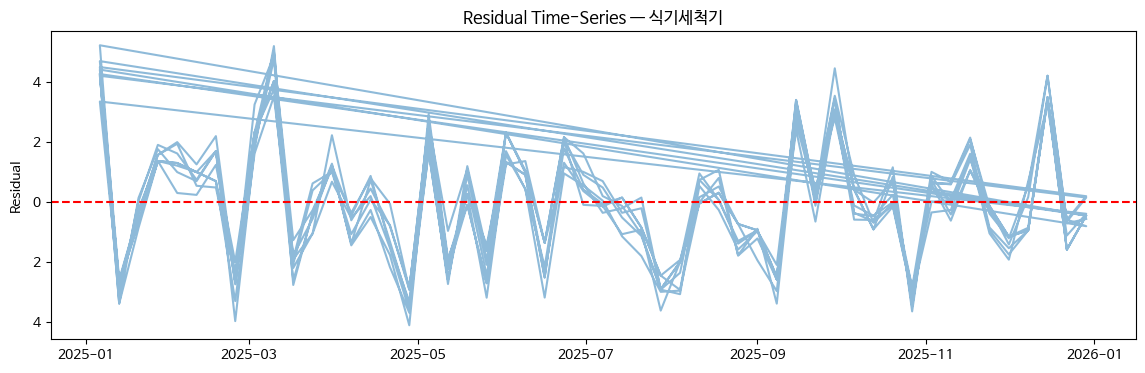

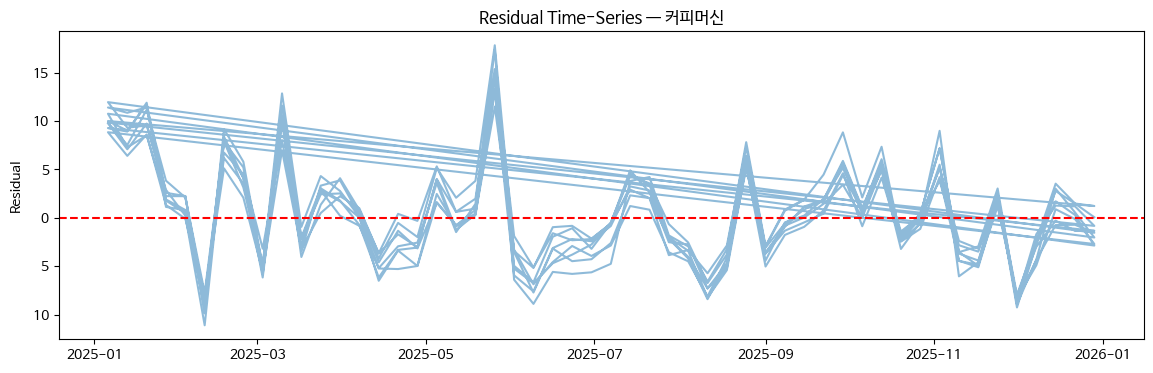

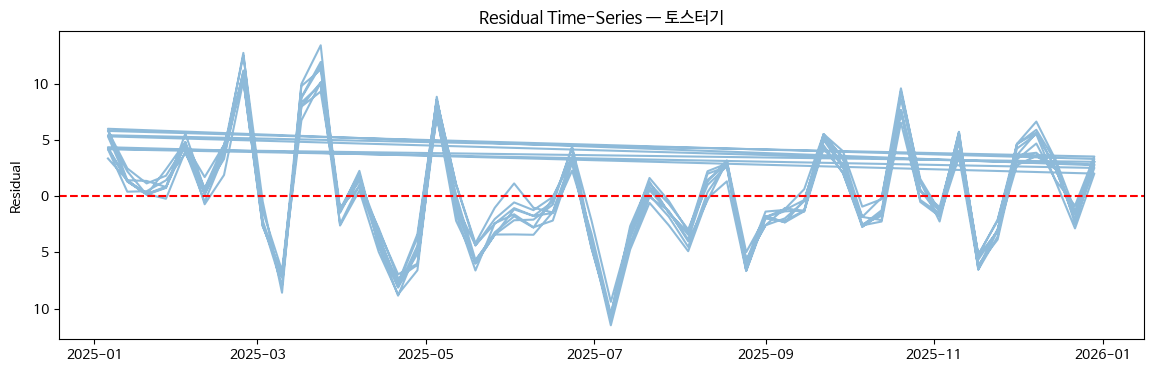

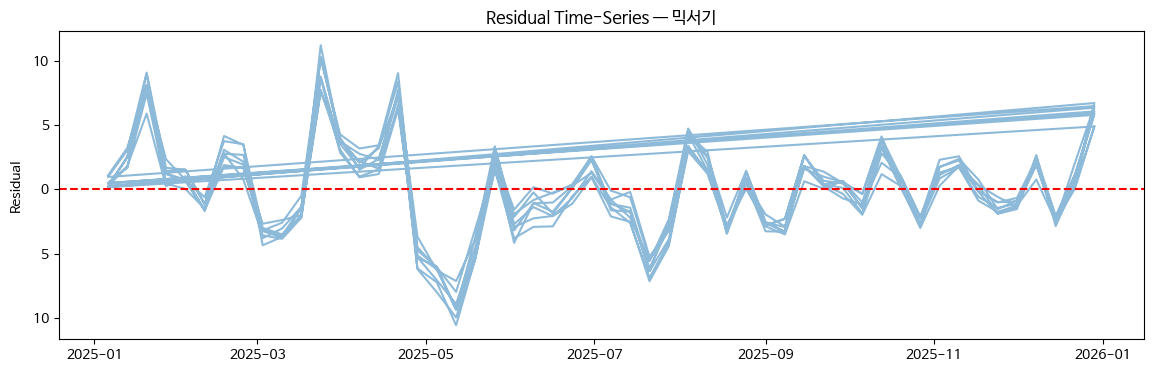

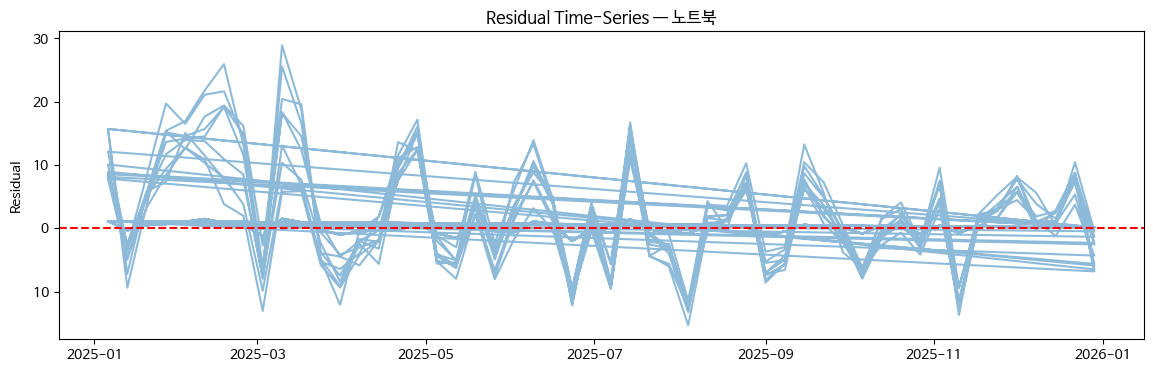

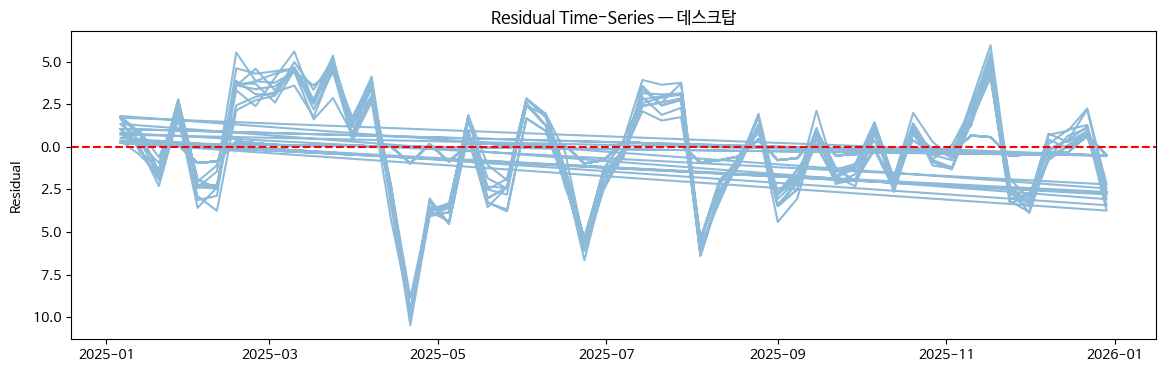

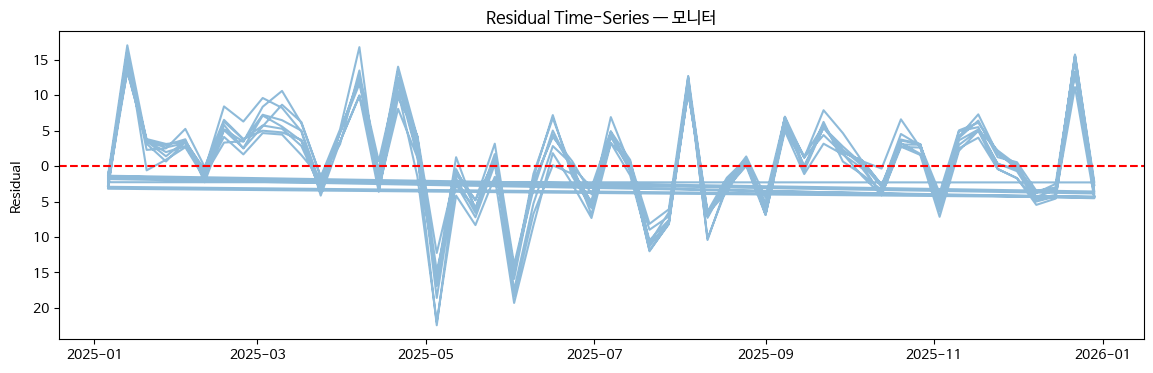

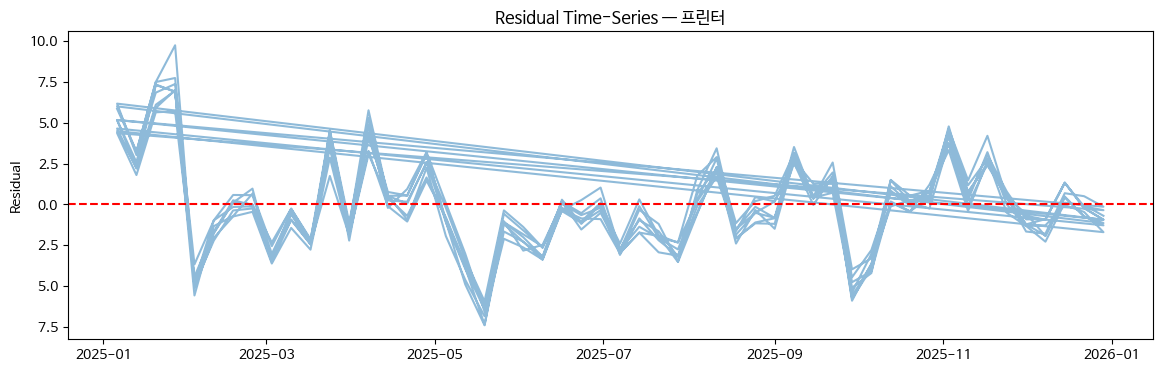

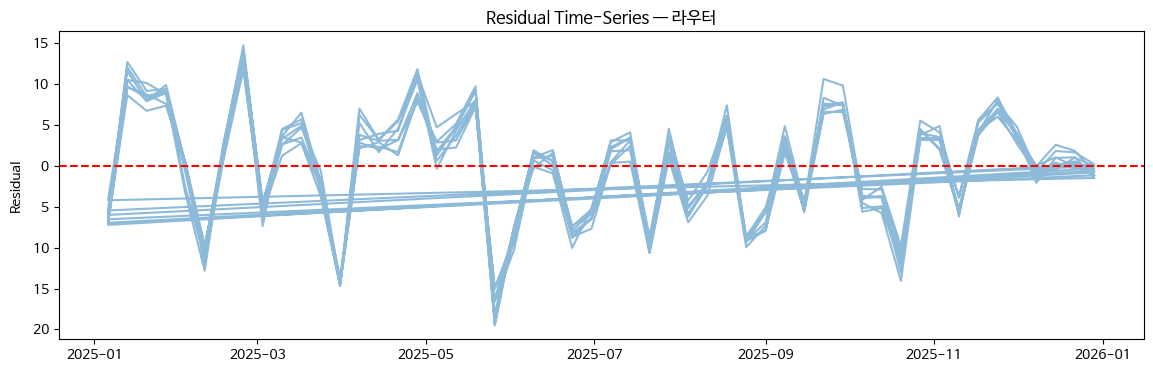

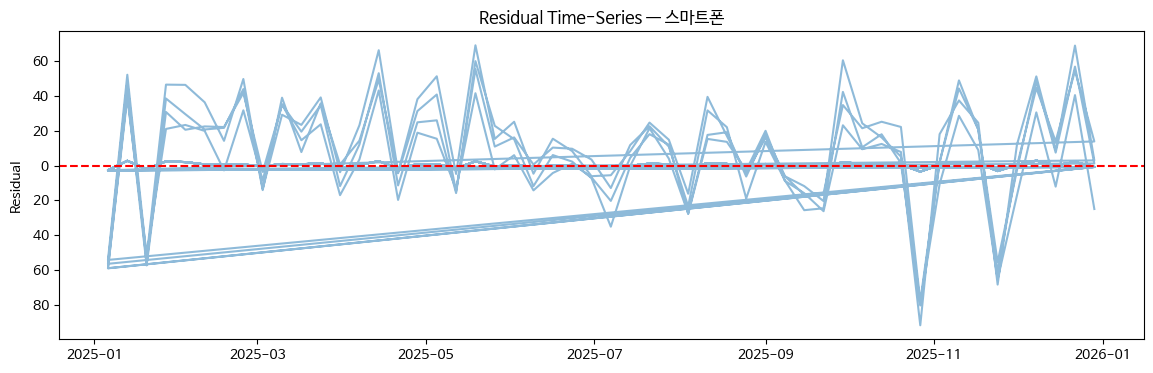

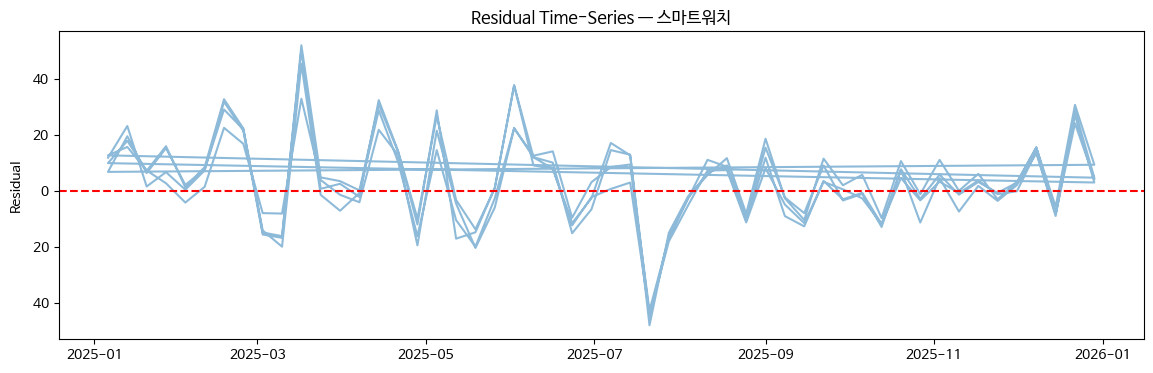

In [21]:
# ===============================================
# 5. Category-level Residual Plot
# ===============================================

cats = df["cat_low"].dropna().unique()

for cat in cats:
    sub = df[df["cat_low"] == cat]
    plt.figure(figsize=(14,4))
    plt.plot(sub["target_date"], sub["residual"], alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Time-Series — {cat}")
    plt.ylabel("Residual")
    plt.show()


In [22]:
# ===============================================
# 6. SKU-level Residual Summary
# ===============================================

sku_res = df.groupby("sku_id")["residual"].agg(["mean","std","median","min","max"])
display(sku_res.sort_values("mean").head(10))   # 가장 underpredict
display(sku_res.sort_values("mean").tail(10))   # 가장 overpredict


,mean,std,median,min,max
sku_id,,,,,
19,-0.723899,6.194679,-0.159640,-13.779395,17.028770
20,-0.537571,5.791757,-1.283308,-13.017922,14.970957
166,-0.437127,3.005273,-0.133059,-9.646041,4.630155
162,-0.404306,2.950429,-0.115962,-9.627570,5.604592
151,-0.392782,3.046922,-0.334561,-9.970482,4.524553
12,-0.367397,7.333419,-0.671406,-14.723001,24.231184
61,-0.353028,9.563591,-1.411401,-20.119804,17.235495
87,-0.351663,3.198636,0.041166,-6.502808,8.487593
93,-0.342393,0.194184,-0.303931,-1.303931,-0.303931


,mean,std,median,min,max
sku_id,,,,,
70,2.618176,15.164204,1.274781,-36.265964,32.990559
63,3.015903,14.805691,2.302004,-29.832934,41.312328
73,3.707730,12.651301,3.326722,-26.414728,41.574183
149,3.792620,9.086946,2.296241,-13.218731,25.569267
203,3.844801,16.677511,2.791093,-45.011009,52.040247
146,4.310699,9.761901,3.763402,-12.161066,28.922984
205,5.582985,16.141441,5.690271,-48.030941,50.229854
197,8.526334,29.839815,16.407021,-77.988562,60.045104
192,9.618250,30.145868,10.918622,-80.421601,56.898867


<Figure size 1000x400 with 0 Axes>

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


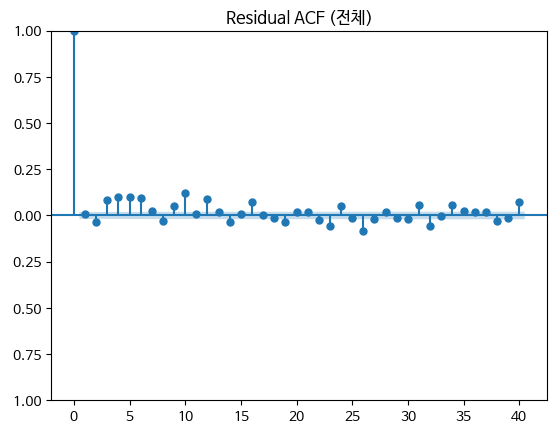

In [23]:
# ===============================================
# 7. Residual ACF (Autocorrelation)
# ===============================================

from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(df["residual"], lags=40)
plt.title("Residual ACF (전체)")
plt.show()


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


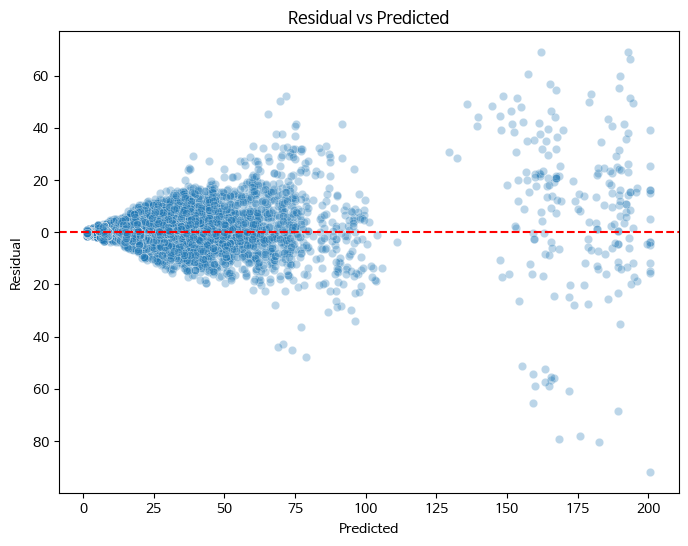

In [24]:
# ===============================================
# 8. Scatter Plot (y_pred vs residual)
# ===============================================

plt.figure(figsize=(8,6))
sns.scatterplot(x=df["y_pred"], y=df["residual"], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [27]:
print("df_actual:", df_actual.shape)
print("df_pred:", df_pred.shape)

df_actual.head()

df_actual: (21000, 4)
df_pred: (21000, 5)


,target_date,sku_id,y,cat_low
0,2024-01-01,1,49,청소기
1,2024-01-08,1,54,세탁기
2,2024-01-15,1,50,공기청정기
3,2024-01-22,1,47,건조기
4,2024-01-29,1,54,공기청정기


In [28]:
df = df_actual.merge(
    df_pred[["target_date", "sku_id", "y_pred"]],
    on=["target_date", "sku_id"],
    how="inner"
)

df["residual"] = df["y"] - df["y_pred"]

df.head()


,target_date,sku_id,y,cat_low,y_pred,residual
0,2024-01-01,1,49,청소기,43.571847,5.428153
1,2024-01-08,1,54,세탁기,58.986727,-4.986727
2,2024-01-15,1,50,공기청정기,51.414892,-1.414892
3,2024-01-22,1,47,건조기,39.468526,7.531474
4,2024-01-29,1,54,공기청정기,51.106999,2.893001


In [29]:
df = df_actual.merge(
    df_pred[["target_date", "sku_id", "y_pred"]],
    on=["target_date", "sku_id"],
    how="inner"
)

df["residual"] = df["y"] - df["y_pred"]

df.head()


,target_date,sku_id,y,cat_low,y_pred,residual
0,2024-01-01,1,49,청소기,43.571847,5.428153
1,2024-01-08,1,54,세탁기,58.986727,-4.986727
2,2024-01-15,1,50,공기청정기,51.414892,-1.414892
3,2024-01-22,1,47,건조기,39.468526,7.531474
4,2024-01-29,1,54,공기청정기,51.106999,2.893001
